# Fundamentals of Bioimage Analysis: I/O and Processing

## Course Introduction

Welcome to the 3rd notebook of the P2N2025 bioimage analysis course! This notebook will teach you the essential skills for processing bio-image data using Python.

## Learning Objectives

By completing this notebook, you will be able to:

1. **Apply basic image processing** operations using scikit-image
2. **Extract features** from segmented objects

## Course Structure
This notebook is divided in 2 chapters:

**Chapter 1: Image Processing with scikit-image**
- Objective: Apply fundamental image processing operations
- Key Concepts: Filtering, intensity adjustments, segmentation

**Chapter 2: Feature Extraction**
- Objective: Learn how to extract  hand-crafted features from segmented objects
- Key Concepts: Feature extraction

## Why This Matters

Modern microscopy generates complex, multidimensional datasets that require computational tools to extract meaningful information. This notebook teaches you the fundamental skills that underpin all bioimage analysis workflows.

**Let's begin!**


# Library installations on Google Colab
When using Google Colab, we have to make sure that all the libraries that we will use are available in its runtime environment.
Unlike local Python environments that we can reuse after a session, Google Colab will reset the environment after a certain amount of time.
Therefore, each time we start a new Google Colab session, we have to install the libraries in the runtime environment. Luckily, Google Colab already comes with many libraries pre-installed. So, we only have to install the libraries that are not pre-installed.

The following code cell will install all required libraries for this notebook.

In [2]:
# Pre-installed libraries (will be skipped automatically)
!pip install numpy
!pip install scikit-image
!pip install matplotlib
!pip install seaborn

# To install
!pip install bioio==3.0.0 bioio-czi==2.4.0 bioio-ome-tiff==1.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 970.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.1/245.1 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.5/458.5 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.5/245.5 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.1/224.1 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/

### Download the image dataset
We will work with a demo microscopy dataset in which HeLa cells have been stained using DAPI, and tubulin and mitochondria antibodies. Hereto, we will download the image dataset into our Google Drive.

In [5]:
import gdown

# a file
url = "https://drive.google.com/uc?id=1tR0yOZ7vOwMz43RacDNw77oGi50pbBrd"
image_path = "/content/hela_prolongdiamond_dapi_tubulin-af488_mitochondria-af568_40x.czi"
gdown.download(url, image_path)

Downloading...
From: https://drive.google.com/uc?id=1tR0yOZ7vOwMz43RacDNw77oGi50pbBrd
To: /content/hela_prolongdiamond_dapi_tubulin-af488_mitochondria-af568_40x.czi
100%|██████████| 88.2M/88.2M [00:01<00:00, 58.7MB/s]


'/content/hela_prolongdiamond_dapi_tubulin-af488_mitochondria-af568_40x.czi'

In [17]:
from bioio import BioImage

# Define the path to the image file
image_path = "/content/hela_prolongdiamond_dapi_tubulin-af488_mitochondria-af568_40x.czi"

# Define a BioImage object
img = BioImage(image_path)
img.set_scene(1)
img_scale = [img.physical_pixel_sizes.Z, img.physical_pixel_sizes.Y, img.physical_pixel_sizes.X]

# Get the raw data as a numpy array
nuclei_channel = 2 # DAPI channel
nuclei_data = img.get_image_data("ZYX", T=0, C=nuclei_channel).astype(float)  # returns 4D CZYX numpy array
print(f'Data type: {type(nuclei_data)}')
print(f'Numpy array shape: {nuclei_data.shape}')

Data type: <class 'numpy.ndarray'>
Numpy array shape: (14, 512, 512)


**Visualize the nuclei**

We can now visualize the nuclei data. As you can see, the nuclei are not very sharp. There is a lot of noise in the image.

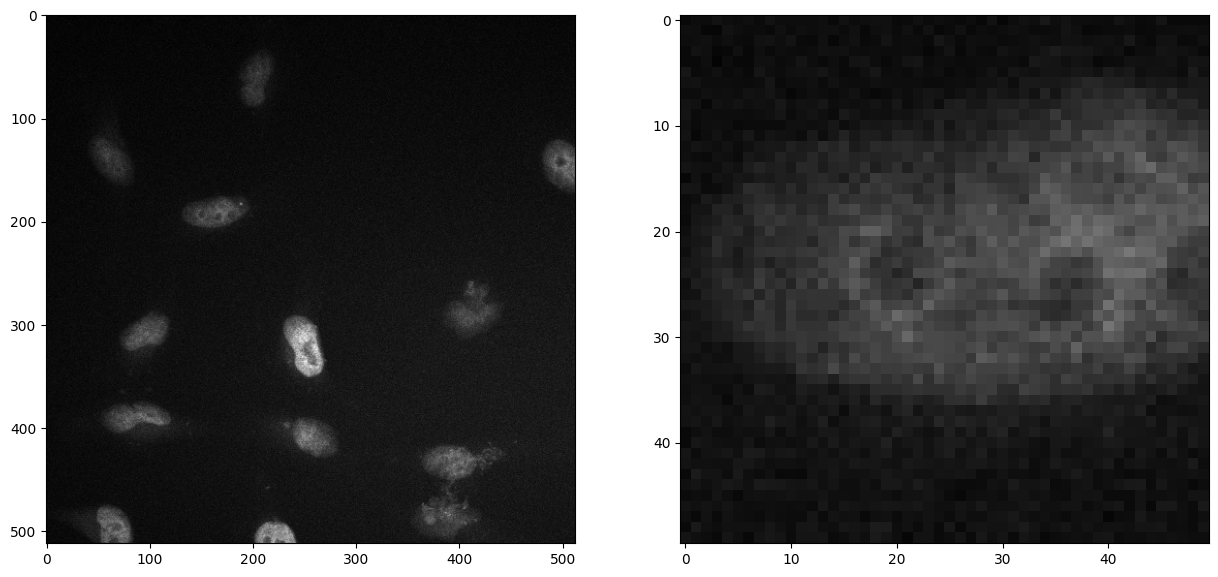

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

z = 7
y_start, y_end = 170, 220
x_start, x_end = 130, 180
noisy_nuclei = nuclei_data[z,:,:].squeeze() # One plane of the nuclei data
noisy_nuclei_zoom = nuclei_data[z, y_start:y_end, x_start:x_end] # In the same plane, zoom in on a part of the nuclei data

fig, axes = plt.subplots(1, 2, figsize=(15,15))
cmap = 'gray'
vmin = noisy_nuclei.min()
vmax = noisy_nuclei.max()
axes[0].imshow(noisy_nuclei, vmin=vmin, vmax=vmax, cmap=cmap)
axes[1].imshow(noisy_nuclei_zoom, vmin=vmin, vmax=vmax, cmap=cmap)
plt.show()

**Filtering**

Using scikit-image, we can apply filters to the image to try to remove the noise.

Here we will compare different filtering methods:
1) Gaussian filter: Convolves the image with a Gaussian kernel, smooths the image, removes high frequency noise
2) Median filter: Replaces each pixel with the median of the pixels in their neighborhood, removes high frequency noise, preserves edges

gaussian range: (37.04753270145128, 1488.1356878116012)
median range: (34.0, 1517.0)


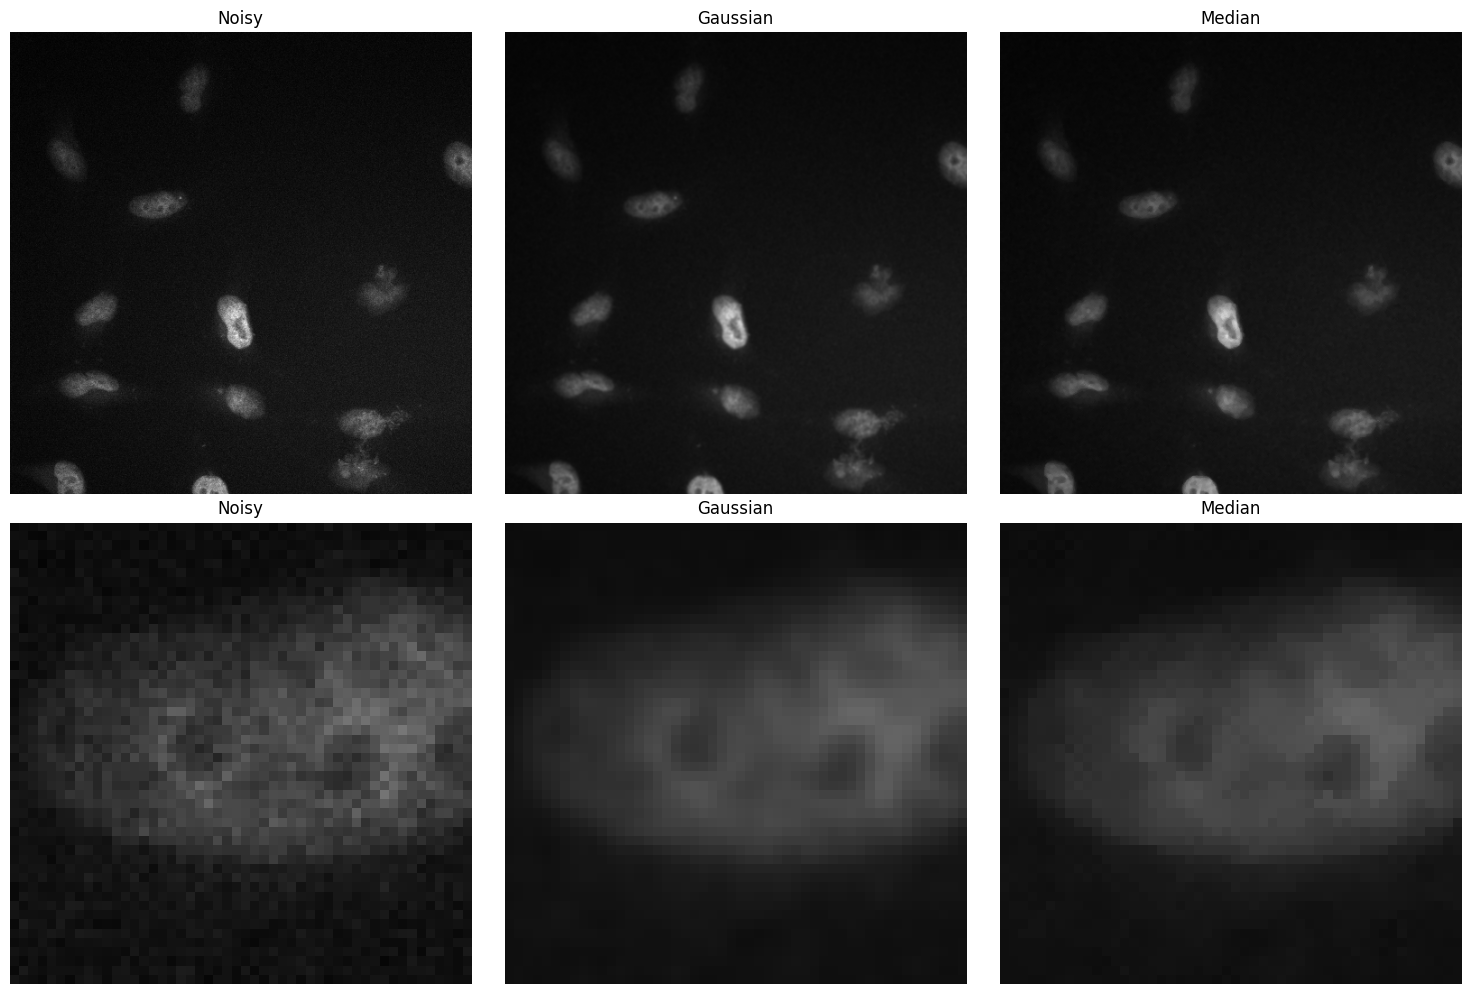

In [43]:
import numpy as np
from skimage import filters
from skimage.filters import gaussian
from skimage.morphology import disk


# Gaussian filter: smooths the image, removes high frequency noise
sigma=1
gaussian_filtered = filters.gaussian(noisy_nuclei, sigma=sigma)
print("gaussian range: ({}, {})".format(np.min(gaussian_filtered), np.max(gaussian_filtered)))

# Median filter: removes high frequency noise, preserves edges
median_filtered = filters.median(noisy_nuclei, footprint=disk(2))
print("median range: ({}, {})".format(np.min(median_filtered), np.max(median_filtered)))

fig, axes = plt.subplots(2, 3, figsize=(15,10))
# First row: entire plane
axes[0,0].imshow(noisy_nuclei, vmin=vmin, vmax=vmax, cmap=cmap)
axes[0,0].set_title("Noisy")
axes[0,0].axis('off')
axes[0,1].imshow(gaussian_filtered, vmin=vmin, vmax=vmax, cmap=cmap)
axes[0,1].set_title("Gaussian")
axes[0,1].axis('off')
axes[0,2].imshow(median_filtered, vmin=vmin, vmax=vmax, cmap=cmap)
axes[0,2].axis('off')
axes[0,2].set_title("Median")

# Second row: zoom in on a part of the image
axes[1,0].imshow(noisy_nuclei[y_start:y_end, x_start:x_end], vmin=vmin, vmax=vmax, cmap=cmap)
axes[1,0].set_title("Noisy")
axes[1,0].axis('off')
axes[1,1].imshow(gaussian_filtered[y_start:y_end, x_start:x_end], vmin=vmin, vmax=vmax, cmap=cmap)
axes[1,1].set_title("Gaussian")
axes[1,1].axis('off')
axes[1,2].imshow(median_filtered[y_start:y_end, x_start:x_end], vmin=vmin, vmax=vmax, cmap=cmap)
axes[1,2].set_title("Median")
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

**Foreground Segmentation using Otsu's method**

To distinguish objects from the backgorund in our image, we could use a threshold on the pixel intensities. This would create a binary mask with 0s for the background and 1s for the objects. However, defining the threshold is not so straightforward. Ideally, we want to do this in a standardized and automated way.

Otsu's method is a thresholding method to split data into two classes. Given a histogram of the data, it finds the threshold that maximizes the between-class variance. In case of images, it uses the histogram of the pixel intensities to find the threshold that will split our image in the background and foreground.

![Otsu's method](https://scipy-lectures.org/_images/sphx_glr_plot_threshold_001.png)

To use this method, we can simply use the `skimage.filters.threshold_otsu` function.

We can compare the impact of the different filtering methods on the results of our segmentation.

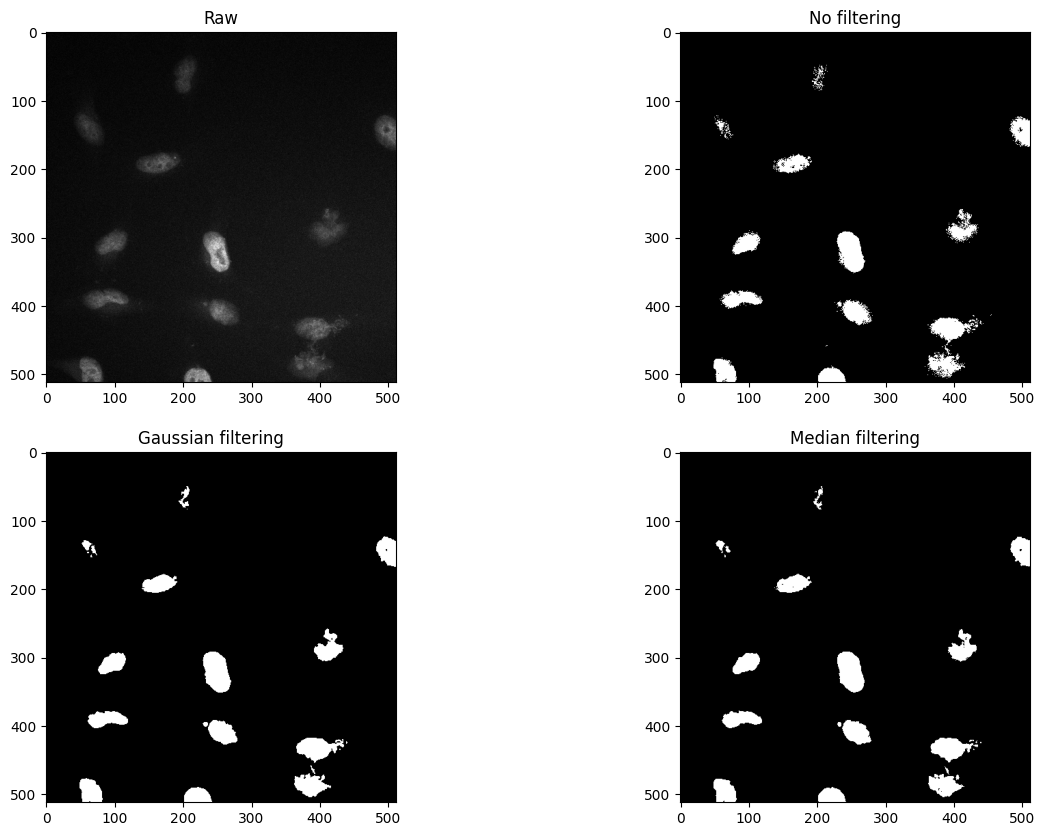

In [44]:
foreground_raw = noisy_nuclei > filters.threshold_otsu(noisy_nuclei)
foreground_gaussian = gaussian_filtered > filters.threshold_otsu(gaussian_filtered)
foreground_median = median_filtered > filters.threshold_otsu(median_filtered)

# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(15,10))
axes[0, 0].imshow(noisy_nuclei, cmap='gray')
axes[0, 0].set_title("Raw")
axes[0, 1].imshow(foreground_raw, cmap='gray')
axes[0, 1].set_title("No filtering")
axes[1, 0].imshow(foreground_gaussian, cmap='gray')
axes[1, 0].set_title("Gaussian filtering    ")
axes[1, 1].imshow(foreground_median, cmap='gray')
axes[1, 1].set_title("Median filtering")
plt.show()

**Background correction**

It turns out that segmenting the nuclei is not as straightforward as one might think. One of the main challenges is the intensity gradient of the background. This makes it difficult to define a threshold that works equally well over the entire image.

We can try to correct for the background intensity gradient by trying to obtain a backgorund image, which we can then subtract from the original image. We will use the rolling ball algorithm to obtain the background image. This is what the rolling ball algorithm does:
- It interprets the image as a landscape, with the height of the pixels corresponding to their intensity.
- It then rolls a ball of a user-defined radius underneath this landscape
- A background image is then constructed by using the height of the ball at each position as the background image.
- We can then subtract the background image from the original image to obtain a background corrected image.

We can use the `skimage.restoration.rolling_ball` function to obtain the background image.


Background_rolling range: (11.0, 89.45130486030294)


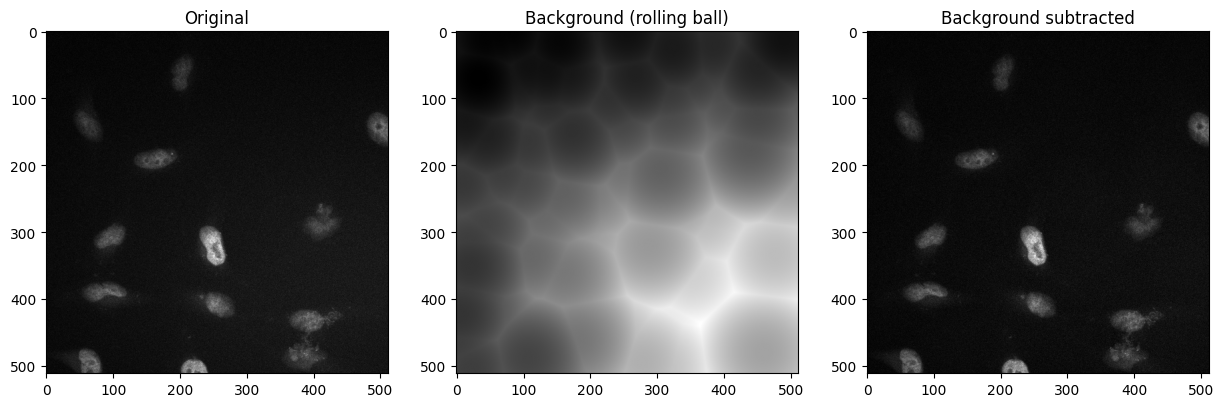

In [54]:
from skimage.restoration import rolling_ball

# Obtain the background image using the rolling ball algorithm
background_rolling = rolling_ball(noisy_nuclei, radius=200)
print(f"Background_rolling range: ({np.min(background_rolling)}, {np.max(background_rolling)})")

# Subtract the background from the original image
nuclei_rolling = noisy_nuclei - background_rolling

fig, axes = plt.subplots(1, 3, figsize=(15,10))
axes[0].imshow(noisy_nuclei, vmin=noisy_nuclei.min(), vmax=noisy_nuclei.max(), cmap=cmap)
axes[0].set_title("Original")
axes[1].imshow(background_rolling, vmin=background_rolling.min(), vmax=background_rolling.max(), cmap=cmap)
axes[1].set_title("Background (rolling ball)")
axes[2].imshow(nuclei_rolling, vmin=nuclei_rolling.min(), vmax=nuclei_rolling.max(), cmap=cmap)
axes[2].set_title("Background subtracted")
plt.show()

We can now see what impact the background correction has on the results of our segmentation. We can also combine this with the filtering approaches we tried earlier.

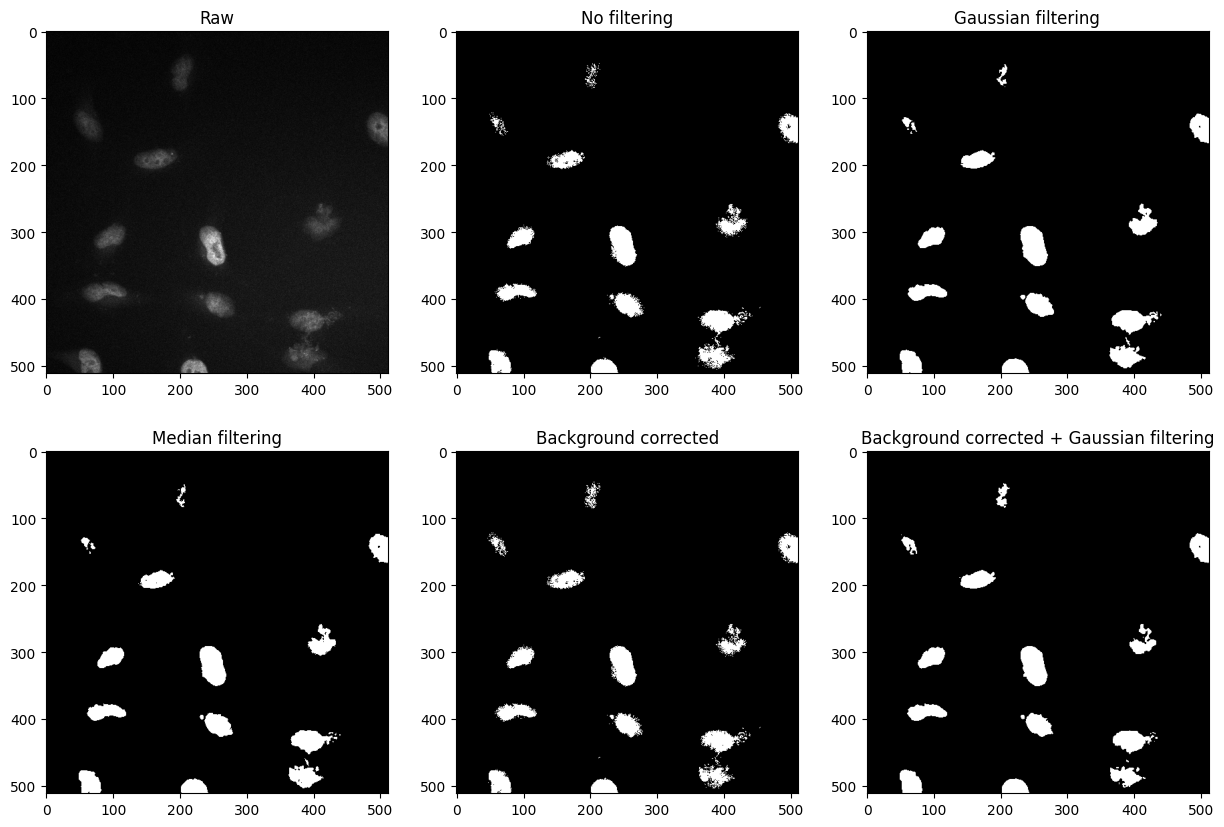

In [55]:
foreground_bg_corrected = nuclei_rolling > filters.threshold_otsu(nuclei_rolling)

nuclei_rolling_gauss = filters.gaussian(nuclei_rolling, sigma=sigma)
foreground_bg_corrected_gauss = nuclei_rolling_gauss > filters.threshold_otsu(nuclei_rolling_gauss)


# Plot the results
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0, 0].imshow(noisy_nuclei, cmap='gray')
axes[0, 0].set_title("Raw")
axes[0, 1].imshow(foreground_raw, cmap='gray')
axes[0, 1].set_title("No filtering")
axes[0, 2].imshow(foreground_gaussian, cmap='gray')
axes[0, 2].set_title("Gaussian filtering    ")
axes[1, 0].imshow(foreground_median, cmap='gray')
axes[1, 0].set_title("Median filtering")
axes[1, 1].imshow(foreground_bg_corrected, cmap='gray')
axes[1, 1].set_title("Background corrected")
axes[1, 2].imshow(foreground_bg_corrected_gauss, cmap='gray')
axes[1, 2].set_title("Background corrected + Gaussian filtering")
plt.show()

There are many different thresholding methods available, of which Otsu's method is one of the most popular. To see which method works best for our data, we can compare the results of the different methods. `scikit-image` has a function `try_all_threshold` that will simply apply all thresholding methods and plot the results.

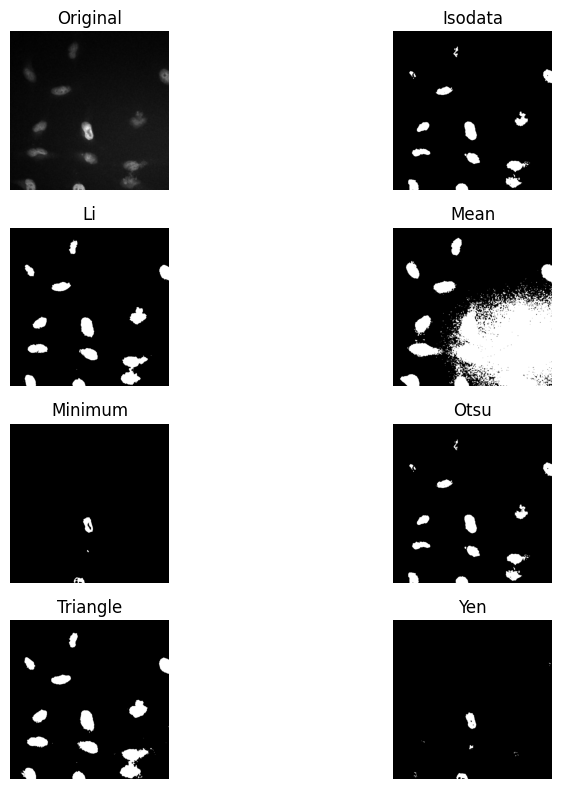

In [56]:
from skimage.filters import try_all_threshold
fig, ax = try_all_threshold(median_filtered, figsize=(10, 8), verbose=False)
plt.show()

# Chapter 1: Image Processing with scikit-image

In this chapter, we will explore how to use `scikit-image` to process images. It contains a lot of functions for image processing, such as filtering, segmentation, feature extraction, etc.

As in the previous notebook, we will use `bioio` to read our image data. We will continue working with the same image.
We will work with the DAPI channel, which stains the nuclei. This is channel 2 in our image.

**Obtain the nuclei data**

# Chapter 2: Extracting features
After segmenting the foreground, we can now continue with extracting features from the individual nuclei. Hereto, we will use the `skimage.measure.regionprops_table` function. This function will return a pandas dataframe, i.e., a table, with the properties of the individual nuclei.

First lets label the individual nuclei in the binary image that we created in the previous chapter

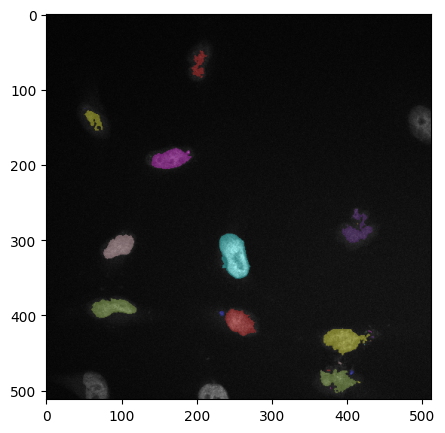

In [58]:
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops_table

# First, we will remove nuclei that are touching the border of the image. These nuclei are incomplete, and we can thus not reliably extract features from them.
# We start from our foreground segmentation.
foreground_bg_corrected_gauss = clear_border(foreground_bg_corrected_gauss)

# Now, we will label the individual nuclei. This will give us a unique identifier for each nucleus.
label_img = label(foreground_bg_corrected_gauss)

# We can now plot an overlay of the labeled image
from skimage.color import label2rgb
image_label_overlay = label2rgb(label_img, image=noisy_nuclei/noisy_nuclei.max(), bg_label=0)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(image_label_overlay)
plt.show()

Next, we extract features from the nuclei using `skimage.measure.regionprops_table` and visualize the results.

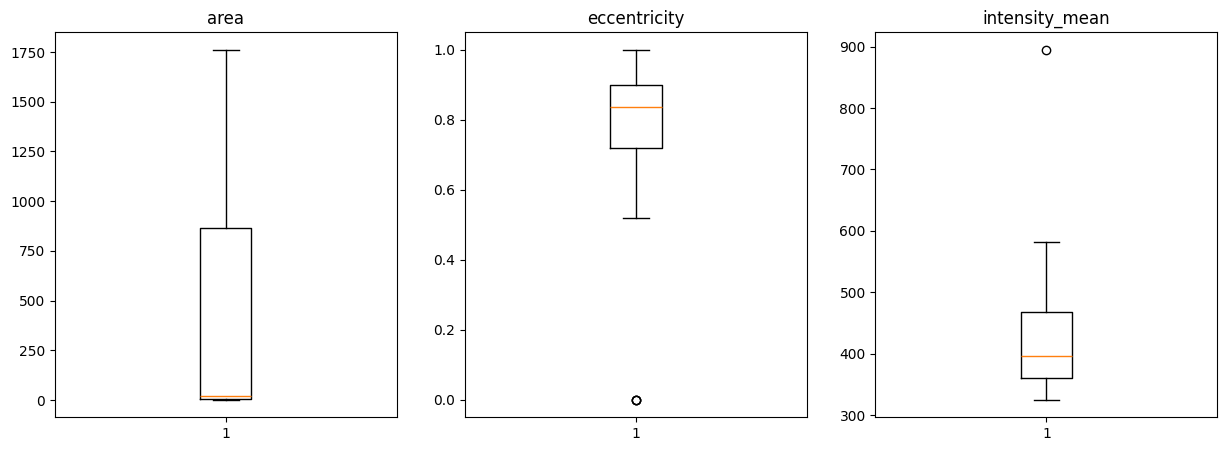

In [62]:
# Extract features
properties = ('area', 'eccentricity', 'intensity_mean')
props = regionprops_table(label_img, median_filtered, properties=properties)

# Plot the results as boxplots
fig, axes = plt.subplots(1, len(properties), figsize=(15, 5))
for i, prop in enumerate(properties):
    axes[i].boxplot(props[prop])
    axes[i].set_title(prop)
plt.show()